In [50]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import ta
import numpy as np
from datetime import datetime, timezone
from math import log, sqrt, exp, erf, ceil
import asyncio
import time
import aiohttp
from dataclasses import dataclass
import requests
from typing import Optional

In [51]:
BINANCE_BASE_URL = "https://api.binance.com"

# Conversion des timeframes Binance en millisecondes
INTERVAL_TO_MS = {
    "1s": 1000,
    "1m": 60 * 1000,
    "3m": 3 * 60 * 1000,
    "5m": 5 * 60 * 1000,
    "15m": 15 * 60 * 1000,
    "30m": 30 * 60 * 1000,
    "1h": 60 * 60 * 1000,
    "2h": 2 * 60 * 60 * 1000,
    "4h": 4 * 60 * 60 * 1000,
    "6h": 6 * 60 * 60 * 1000,
    "8h": 8 * 60 * 60 * 1000,
    "12h": 12 * 60 * 60 * 1000,
    "1d": 24 * 60 * 60 * 1000,
    "3d": 3 * 24 * 60 * 60 * 1000,
    "1w": 7 * 24 * 60 * 60 * 1000,
    "1M": 30 * 24 * 60 * 60 * 1000,  # approximation
}

def get_options_data(currency, target_date):
    url = "https://www.deribit.com/api/v2/public/get_book_summary_by_currency"
    params = {
        "currency": currency,
        "kind": "option"
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()

        if 'result' not in data:
            print("Erreur lors de la récupération des données")
            return

        options_list = []

        print(f"Recherche des options pour l'échéance : {target_date}...")

        for entry in data['result']:
            instrument_name = entry['instrument_name']
            parts = instrument_name.split('-')
            
            if len(parts) == 4:
                exp_date = parts[1]
                strike = float(parts[2])
                option_type = parts[3]  # 'C' ou 'P'

                if exp_date == target_date:
                    options_list.append({
                        'Strike': strike,
                        'Type': 'Call' if option_type == 'C' else 'Put',
                        'Mark Price ($)': entry['mark_price'] * entry['underlying_price'],
                        'Mark Price (BTC)': entry['mark_price'],
                        'Bid': entry['bid_price'],
                        'Ask': entry['ask_price']
                    })

        df = pd.DataFrame(options_list)
        
        if not df.empty:
            df = df.sort_values(by=['Strike'])
            return df
        else:
            print(f"Aucune option trouvée pour la date {target_date}")

    except Exception as e:
        print(f"Une erreur est survenue : {e}")


async def _fetch_klines_chunk(
    session: aiohttp.ClientSession,
    symbol: str,
    interval: str,
    start_time: int,
    limit: int,
    base_url: str = BINANCE_BASE_URL,
    max_retries: int = 3,
):
    url = f"{base_url}/api/v3/klines"
    params = {
        "symbol": symbol.upper(),
        "interval": interval,
        "startTime": start_time,
        "limit": limit,
    }

    for attempt in range(max_retries):
        try:
            async with session.get(url, params=params, timeout=10) as resp:
                if resp.status == 200:
                    return await resp.json()

                # Erreurs de rate limit / bannissement temporaire
                if resp.status in (418, 429):
                    text = await resp.text()
                    raise RuntimeError(
                        f"Rate limit ou ban temporaire Binance (HTTP {resp.status}): {text}"
                    )

                # Autres erreurs -> retry
                text = await resp.text()
                await asyncio.sleep(2 ** attempt)
        except asyncio.TimeoutError:
            if attempt == max_retries - 1:
                raise
            await asyncio.sleep(2 ** attempt)

    raise RuntimeError("Échec de récupération des klines après plusieurs tentatives.")


async def _get_klines_async(symbol: str, interval: str, n_candles: int) -> pd.DataFrame:
    if interval not in INTERVAL_TO_MS:
        raise ValueError(f"Interval '{interval}' non supporté.")

    if n_candles <= 0:
        raise ValueError("n_candles doit être > 0.")

    interval_ms = INTERVAL_TO_MS[interval]
    now_ms = int(time.time() * 1000)

    # On prend la dernière bougie "alignée" sur l'intervalle
    last_open_time = now_ms - (now_ms % interval_ms)

    # Open time de la première bougie souhaitée
    earliest_open_time = last_open_time - (n_candles - 1) * interval_ms

    # On découpe en chunks de max 1000 bougies (limite Binance)
    max_limit = 1000
    n_chunks = ceil(n_candles / max_limit)

    chunks = []
    for i in range(n_chunks):
        chunk_size = min(max_limit, n_candles - i * max_limit)
        chunk_start = earliest_open_time + i * max_limit * interval_ms

        chunks.append(
            {
                "index": i,
                "start_time": chunk_start,
                "limit": chunk_size,
            }
        )

    all_results = [None] * n_chunks

    async with aiohttp.ClientSession() as session:
        # On envoie au max 10 requêtes par "batch", avec 1s de pause entre les batchs
        for batch_start in range(0, n_chunks, 10):
            batch = chunks[batch_start : batch_start + 10]

            tasks = [
                asyncio.create_task(
                    _fetch_klines_chunk(
                        session=session,
                        symbol=symbol,
                        interval=interval,
                        start_time=chunk["start_time"],
                        limit=chunk["limit"],
                    )
                )
                for chunk in batch
            ]

            results = await asyncio.gather(*tasks)

            # On stocke les résultats au bon index pour garder l'ordre temporel
            for chunk, data in zip(batch, results):
                all_results[chunk["index"]] = data

            # Si d'autres batchs à venir, pause 1 seconde => max 10 req/s
            if batch_start + 10 < n_chunks:
                await asyncio.sleep(1)

    # Flatten de tous les chunks
    klines = [item for sublist in all_results for item in sublist]

    # Colonnes Binance
    cols = [
        "open_time",
        "open",
        "high",
        "low",
        "close",
        "volume",
        "close_time",
        "quote_volume",
        "n_trades",
        "taker_base_volume",
        "taker_quote_volume",
        "ignore",
    ]

    df = pd.DataFrame(klines, columns=cols)

    # Typage des colonnes
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")

    numeric_cols = [
        "open",
        "high",
        "low",
        "close",
        "volume",
    ]
    df[numeric_cols] = df[numeric_cols].astype(float)

    # On garde seulement les n_candles dernières au cas où
    df = df.sort_values("open_time").tail(n_candles).reset_index(drop=True)
    df = df[["open_time", "open", "high", "low", "close", "volume"]]
    df = df.rename(columns={"open_time": "date"})
    df.set_index("date", inplace=True)

    return df


def get_binance_ohlcv(symbol: str, interval: str, n_candles: int) -> pd.DataFrame:
    return asyncio.run(_get_klines_async(symbol, interval, n_candles))

async def get_binance_ohlcv_async(symbol: str, interval: str, n_candles: int) -> pd.DataFrame:
    return await _get_klines_async(symbol, interval, n_candles)

df = await get_binance_ohlcv_async("BTCUSDT", "1h", 365*24)
df

,open,high,low,close,volume
date,,,,,
2024-12-05 18:00:00,101282.37,101521.14,100172.67,100179.24,3771.11550
2024-12-05 19:00:00,100179.24,100932.00,98599.36,99028.00,4094.54231
2024-12-05 20:00:00,99028.01,99424.00,97888.00,99072.84,5619.97633
2024-12-05 21:00:00,99072.84,99479.72,98801.93,98908.02,1883.42416
2024-12-05 22:00:00,98908.01,99040.00,90500.00,96589.04,14364.88865
...,...,...,...,...,...
2025-12-05 13:00:00,91242.40,91352.56,90215.51,90465.14,1524.52886
2025-12-05 14:00:00,90465.14,90744.24,89874.70,90287.67,1551.13670
2025-12-05 15:00:00,90287.67,91478.67,90258.24,90459.35,1911.11908


In [52]:
@dataclass
class SimulationResult:
    ST: np.ndarray       # prix terminaux (n_sims,)
    S0: float            # spot initial
    T: float             # maturité en années
    close_paths: np.ndarray | None = None  # (n_sims, n_periods) ou None
    high_paths: np.ndarray | None = None
    low_paths: np.ndarray | None = None

class BootstrapOptionModel:
    def __init__(
        self,
        df: pd.DataFrame,
        *,
        col_close: str = "close",
        n_sims: int = 100_000,
        max_reuse: int = 3,
        noise_std: float = 0.0,
        centering: bool = True,
    ):
        if col_close not in df.columns:
            raise ValueError(f"Colonne '{col_close}' absente du DataFrame.")
        if "high" not in df.columns or "low" not in df.columns:
            raise ValueError("Les colonnes 'high' et 'low' sont requises dans df.")
        if len(df[col_close]) < 2:
            raise ValueError("Le DataFrame doit contenir au moins 2 clôtures.")

        self.df = df.copy()
        self.col_close = col_close

        # paramètres généraux
        self.n_sims = n_sims
        self.max_reuse = max_reuse
        self.noise_std = noise_std
        self.centering = centering

        # Pré-calculs sur l'historique
        close = self.df[self.col_close].astype(float).to_numpy()
        high = self.df["high"].astype(float).to_numpy()
        low  = self.df["low"].astype(float).to_numpy()

        self.S0 = float(close[-1])

        self.logret_raw = np.diff(np.log(close))
        self.n_returns = len(self.logret_raw)
        if self.n_returns == 0:
            raise ValueError("Impossible de calculer des rendements sur cet échantillon.")

        self.high_factor = high[1:] / close[1:]
        self.low_factor  = low[1:]  / close[1:]

        if len(self.high_factor) != self.n_returns or len(self.low_factor) != self.n_returns:
            raise RuntimeError("Problème d'alignement logret vs high/low.")

        self.mu_hist = float(self.logret_raw.mean())

    @staticmethod
    def _sample_indices_with_cap(n_returns: int, horizon: int, max_reuse: int, rng: np.random.Generator):
        pool = np.repeat(np.arange(n_returns), max_reuse)
        if horizon > len(pool):
            raise ValueError(
                f"horizon={horizon} > n_returns*max_reuse={len(pool)} : "
                f"augmente max_reuse ou l'historique."
            )
        sel = rng.choice(pool, size=horizon, replace=False)
        return sel

    def _compute_horizon(self, end_date: str):
        fmt = "%Y-%m-%d %H:%M:%S"
        dt_end = datetime.strptime(end_date, fmt).replace(tzinfo=timezone.utc)
        now_utc = datetime.now(timezone.utc)
        delta = dt_end - now_utc
        n_periods = int(delta.total_seconds() / 3600)

        if n_periods <= 0:
            raise ValueError(
                f"end_date={end_date} doit être dans le futur (UTC). "
                f"Horizon calculé n_periods={n_periods}."
            )

        T_years = n_periods / (365 * 24)
        return n_periods, T_years

    def simulate(
        self,
        end_date: str,
        *,
        n_sims: int | None = None,
        seed: int | None = None,
        with_paths: bool = False,
    ) -> SimulationResult:
        n_sims = n_sims or self.n_sims

        rng = np.random.default_rng(seed)

        # log-returns ajustés
        if self.centering:
            logret = (self.logret_raw - self.mu_hist)
        else:
            logret = self.logret_raw

        n_periods, T_years = self._compute_horizon(end_date)

        ST = np.empty(n_sims)

        close_paths = high_paths = low_paths = None
        if with_paths:
            close_paths = np.empty((n_sims, n_periods))
            high_paths  = np.empty_like(close_paths)
            low_paths   = np.empty_like(close_paths)

        for i in range(n_sims):
            idx = self._sample_indices_with_cap(self.n_returns, n_periods, self.max_reuse, rng)

            r  = logret[idx].copy()
            hf = self.high_factor[idx].copy()
            lf = self.low_factor[idx].copy()

            if self.noise_std > 0.0:
                r += rng.normal(loc=0.0, scale=self.noise_std, size=r.shape)

            close_path = self.S0 * np.exp(np.cumsum(r))
            high_path  = close_path * hf
            low_path   = close_path * lf

            ST[i] = close_path[-1]

            if with_paths:
                close_paths[i, :] = close_path
                high_paths[i, :]  = high_path
                low_paths[i, :]   = low_path

        return SimulationResult(
            ST=ST,
            S0=self.S0,
            T=T_years,
            close_paths=close_paths,
            high_paths=high_paths,
            low_paths=low_paths,
        )

    @staticmethod
    def _call_prices_from_paths(ST: np.ndarray, strikes: np.ndarray, T: float) -> np.ndarray:
        payoff = np.maximum(ST[:, None] - strikes[None, :], 0.0)
        disc = np.exp(0 * T)
        return disc * payoff.mean(axis=0)

    @staticmethod
    def _put_prices_from_paths(ST: np.ndarray, strikes: np.ndarray, T: float) -> np.ndarray:
        payoff = np.maximum(strikes[None, :] - ST[:, None], 0.0)
        disc = np.exp(0 * T)
        return disc * payoff.mean(axis=0)

    def price_from_sim(
        self,
        sim: SimulationResult,
        strikes: np.ndarray,
        deribit_df: pd.DataFrame | None = None,
        deribit_price_col: str = "Mark Price ($)",
    ) -> pd.DataFrame:
        call_prices = self._call_prices_from_paths(sim.ST, strikes, T=sim.T)
        put_prices  = self._put_prices_from_paths(sim.ST, strikes, T=sim.T)

        df_out = pd.DataFrame({
            "spot": sim.S0,
            "T_years": sim.T,
            "strike": strikes,
            "call_price_model": call_prices,
            "put_price_model": put_prices,
        })

        if deribit_df is not None and not deribit_df.empty:
            d = deribit_df.pivot(
                index="Strike",
                columns="Type",
                values=deribit_price_col
            )

            d = d.rename(columns={
                "Call": "call_price_deribit",
                "Put": "put_price_deribit"
            }).reset_index()

            df_out = df_out.merge(
                d,
                how="left",
                left_on="strike",
                right_on="Strike"
            ).drop(columns=["Strike"])

            if "call_price_deribit" in df_out.columns:
                df_out["call_diff_pct"] = 100.0 * (
                    df_out["call_price_model"] - df_out["call_price_deribit"]
                ) / df_out["call_price_deribit"]

            if "put_price_deribit" in df_out.columns:
                df_out["put_diff_pct"] = 100.0 * (
                    df_out["put_price_model"] - df_out["put_price_deribit"]
                ) / df_out["put_price_deribit"]

            # Moyenne des écarts (en valeur absolue, plus parlant)
            if "call_diff_pct" in df_out.columns:
                mean_call = df_out["call_diff_pct"].abs().mean(skipna=True)
                print(f"Moyenne écart relatif CALLs (|model - Deribit|) : {mean_call:.2f}%")

            if "put_diff_pct" in df_out.columns:
                mean_put = df_out["put_diff_pct"].abs().mean(skipna=True)
                print(f"Moyenne écart relatif PUTs  (|model - Deribit|) : {mean_put:.2f}%")

        return df_out

    def prob_finish_above_from_sim(self, sim: SimulationResult, targets) -> pd.DataFrame:
        targets = np.asarray(targets, dtype=float)
        probs = (sim.ST[:, None] > targets[None, :]).mean(axis=0)

        return (
            pd.DataFrame({
                "spot": sim.S0,
                "T_years": sim.T,
                "target": targets,
                "prob_finish_above": probs * 100.0,
            })
            .sort_values(by="target", ascending=True)
            .reset_index(drop=True)
        )

    def prob_finish_below_from_sim(self, sim: SimulationResult, targets) -> pd.DataFrame:
        targets = np.asarray(targets, dtype=float)
        probs = (sim.ST[:, None] < targets[None, :]).mean(axis=0)

        return (
            pd.DataFrame({
                "spot": sim.S0,
                "T_years": sim.T,
                "target": targets,
                "prob_finish_below": probs * 100.0,
            })
            .sort_values(by="target", ascending=True)
            .reset_index(drop=True)
        )

    def touch_prob_from_sim(self, sim: SimulationResult, targets) -> pd.DataFrame:
        if sim.high_paths is None or sim.low_paths is None:
            raise ValueError("Les chemins high/low sont nécessaires (simuler avec with_paths=True).")

        targets = np.asarray(targets, dtype=float)
        n_sims_eff, _ = sim.close_paths.shape
        hits = np.zeros_like(targets, dtype=int)

        up_mask      = targets > sim.S0
        down_mask    = targets < sim.S0
        at_spot_mask = targets == sim.S0

        hits[at_spot_mask] = n_sims_eff

        up_targets   = targets[up_mask]
        down_targets = targets[down_mask]

        max_high = sim.high_paths.max(axis=1)
        min_low  = sim.low_paths.min(axis=1)

        if up_targets.size > 0:
            hit_up_matrix = max_high[:, None] >= up_targets[None, :]
            hits[up_mask] = hit_up_matrix.sum(axis=0)

        if down_targets.size > 0:
            hit_down_matrix = min_low[:, None] <= down_targets[None, :]
            hits[down_mask] = hit_down_matrix.sum(axis=0)

        probs = hits / float(n_sims_eff)

        return (
            pd.DataFrame({
                "spot": sim.S0,
                "T_years": sim.T,
                "target": targets,
                "prob_touch": probs * 100.0,
            })
            .sort_values(by="target", ascending=False)
            .reset_index(drop=True)
        )

    def plot_paths(self, sim: SimulationResult, visible_paths: Optional[int] = None):
        paths = sim.close_paths  # shape: (n_paths, n_periods)
        n_paths, n_periods = paths.shape

        # --- Sélection aléatoire des paths visibles ---
        if visible_paths is not None and visible_paths > 0 and visible_paths < n_paths:
            idx = np.random.choice(n_paths, size=visible_paths, replace=False)
            paths_to_plot = paths[idx]
        else:
            # visible_paths == None ou >= n_paths -> on trace tout
            paths_to_plot = paths

        hist_len = max(1, int(0.25 * n_periods))

        close_series = self.df["close"]

        if hist_len + 1 > len(close_series):
            hist_len = max(1, len(close_series) - 1)

        hist_segment = close_series.iloc[-(hist_len + 1):].values
        S0 = hist_segment[-1]

        t_hist_hours = np.arange(-hist_len, 1) 
        t_paths_hours = np.arange(n_periods)

        t_hist_days = t_hist_hours / 24
        t_paths_days = t_paths_hours / 24

        # --- Plot ---
        plt.figure(figsize=(10, 6))

        # 1) Historique
        plt.plot(t_hist_days, hist_segment, label="Historique (close)", linewidth=2)

        # 2) Paths simulés
        for i, path in enumerate(paths_to_plot):
            label = "Paths simulés" if i == 0 else None
            plt.plot(t_paths_days, path, alpha=0.4, linewidth=1, label=label)

        # Ligne horizontale au niveau de S0 (facultatif, mais tu l’avais déjà)
        plt.axhline(S0, linestyle="--", label="Prix initial (S0)")

        plt.xlabel("Temps (jours, 0 = début simulation)")
        plt.ylabel("Prix")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [39]:
model = BootstrapOptionModel(
    df=df,
    max_reuse=3,
    noise_std=0.0,
    centering=True,
)

end_date = "2025-12-26 08:00:00"
sim = model.simulate(end_date=end_date, n_sims=100_000, with_paths=True)
strikes = np.array([60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000])

deribit_df = get_options_data("BTC", "26DEC25")

curve = model.price_from_sim(sim, strikes, deribit_df=deribit_df)
curve

Recherche des options pour l'échéance : 26DEC25...
Moyenne écart relatif CALLs (|model - Deribit|) : 24.37%
Moyenne écart relatif PUTs  (|model - Deribit|) : 32.88%


,spot,T_years,strike,call_price_model,put_price_model,call_price_deribit,put_price_deribit,call_diff_pct,put_diff_pct
0,91030.57,0.056621,60000,31536.899752,0.288773,31233.576038,58.018290,0.971146,-99.502273
1,91030.57,0.056621,70000,21555.537564,18.926585,21407.659345,232.463093,0.690772,-91.858241
2,91030.57,0.056621,80000,11992.683016,456.072037,12144.754677,969.904015,-1.252159,-52.977611
3,91030.57,0.056621,90000,4693.685384,3157.074405,4727.702979,3553.229874,-0.719537,-11.149165
4,91030.57,0.056621,100000,1169.748917,9633.137938,1101.925721,9927.815101,6.154970,-2.968198
5,91030.57,0.056621,110000,189.461609,18652.850630,229.449060,19055.725702,-17.427594,-2.114194
6,91030.57,0.056621,120000,22.294851,28485.683873,81.995329,28908.646706,-72.809608,-1.463101
7,91030.57,0.056621,130000,1.939720,38465.328741,38.026634,38865.001596,-94.899049,-1.028362


In [37]:
model = BootstrapOptionModel(
    df=df,
    max_reuse=3,
    noise_std=0,
    centering=True,
)

end_date = "2026-01-01 05:00:00"

sim = model.simulate(end_date=end_date, n_sims=100_000, with_paths=True)

targets = np.array([65000, 70000, 75000, 80000, 95000, 100000, 105000, 110000, 115000, 120000, 130000]) 

result = model.touch_prob_from_sim(sim, targets)
result

,spot,T_years,target,prob_touch
0,90826.55,0.072831,130000.0,0.328
1,90826.55,0.072831,120000.0,2.224
2,90826.55,0.072831,115000.0,5.090
3,90826.55,0.072831,110000.0,11.360
4,90826.55,0.072831,105000.0,23.137
5,90826.55,0.072831,100000.0,42.903
6,90826.55,0.072831,95000.0,71.275
7,90826.55,0.072831,80000.0,31.955
8,90826.55,0.072831,75000.0,12.677
9,90826.55,0.072831,70000.0,3.645


In [44]:
model = BootstrapOptionModel(
    df=df,
    max_reuse=3,
    noise_std=0,
    centering=True,
)

end_date = "2025-12-07 17:00:00"

sim = model.simulate(end_date=end_date, n_sims=100_000, with_paths=True)

targets = np.array([82000, 84000, 86000, 88000, 90000, 92000, 94000, 96000, 98000, 100000, 102000]) 

result = model.prob_finish_above_from_sim(sim, targets)
result

,spot,T_years,target,prob_finish_above
0,88649.76,0.005479,82000.0,98.761
1,88649.76,0.005479,84000.0,94.546
2,88649.76,0.005479,86000.0,82.313
3,88649.76,0.005479,88000.0,59.326
4,88649.76,0.005479,90000.0,32.563
5,88649.76,0.005479,92000.0,13.071
6,88649.76,0.005479,94000.0,4.061
7,88649.76,0.005479,96000.0,0.946
8,88649.76,0.005479,98000.0,0.191
9,88649.76,0.005479,100000.0,0.027


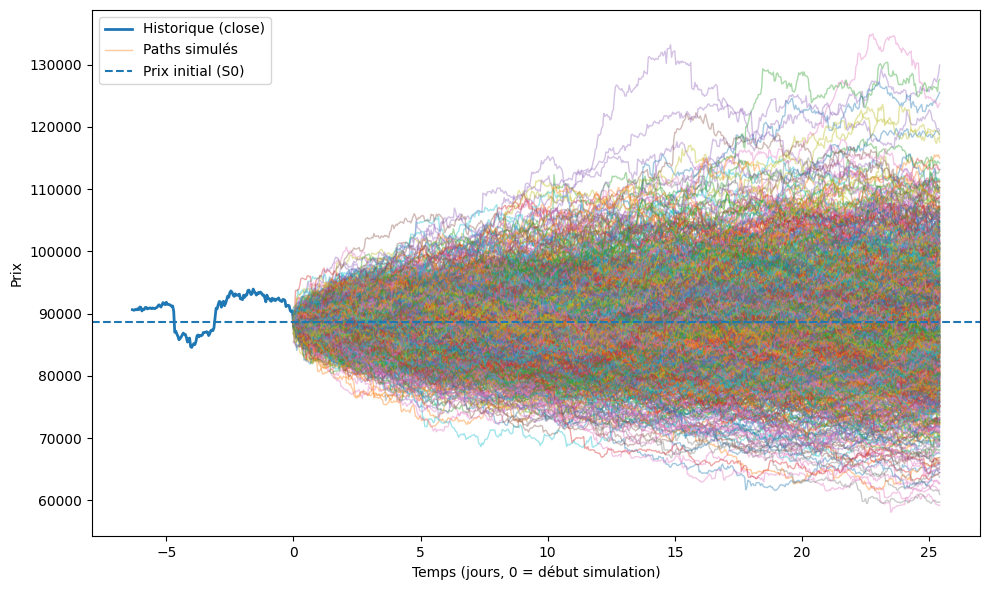

In [49]:
model = BootstrapOptionModel(
    df=df,
    max_reuse=3,
    noise_std=0.0,
    centering=False,
)

end_date = "2025-12-31 05:00:00"
sim = model.simulate(end_date=end_date, n_sims=1000, with_paths=True)
model.plot_paths(sim, visible_paths=1000)

In [54]:
def ev_yes(price_market: float, p_personal_yes: float, usd_size: float = 100) -> float:
    return usd_size * ((p_personal_yes / price_market) - 1)


def ev_no(price_market: float, p_personal_yes: float, usd_size: float = 100) -> float:
    p_no = 1 - p_personal_yes
    price_no = 1 - price_market
    return usd_size * ((p_no / price_no) - 1)


def kelly_yes(price_market: float, p_personal_yes: float) -> float:
    m = price_market
    p = p_personal_yes
    return (p - m) / (1 - m)


def kelly_no(price_market: float, p_personal_yes: float) -> float:
    m = price_market
    p = p_personal_yes
    return (m - p) / m


def stake_size_yes(
    balance: float,
    price_market: float,
    p_personal_yes: float,
    kelly_fraction: float = 0.25,
) -> float:
    f_kelly = kelly_yes(price_market, p_personal_yes)
    f = kelly_fraction * f_kelly
    usd_size = balance * f
    ev = ev_yes(price_market, p_personal_yes, usd_size)
    print(
        f"usd_size: {round(usd_size, 2)} $ | ev: {round(ev, 2)} $ | ev_pct: {round(ev / usd_size * 100, 2)} %"
    )


def stake_size_no(
    balance: float,
    price_market: float,
    p_personal_yes: float,
    kelly_fraction: float = 0.25,
) -> float:
    f_kelly = kelly_no(price_market, p_personal_yes)
    f = kelly_fraction * f_kelly
    usd_size = balance * f
    ev = ev_no(price_market, p_personal_yes, usd_size)
    print(
        f"usd_size: {round(usd_size, 2)} $ | ev: {round(ev, 2)} $ | ev_pct: {round(ev / usd_size * 100, 2)} %"
    )


stake_size_yes(balance=1000, price_market=0.75, p_personal_yes=0.90, kelly_fraction=0.25)
# stake_size_no(balance=1000, price_market=0.03, p_personal_yes=0.95, kelly_fraction=0.2)

usd_size: 150.0 $ | ev: 30.0 $ | ev_pct: 20.0 %
